In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

In [84]:
df = pd.read_csv("balanced-all.csv")
df.head()

,filename,gender
0,data/cv-other-train/sample-069205.npy,female
1,data/cv-valid-train/sample-063134.npy,female
2,data/cv-other-train/sample-080873.npy,female
3,data/cv-other-train/sample-105595.npy,female
4,data/cv-valid-train/sample-144613.npy,female


In [85]:
df.tail()

,filename,gender
66933,data/cv-valid-train/sample-171098.npy,male
66934,data/cv-other-train/sample-022864.npy,male
66935,data/cv-valid-train/sample-080933.npy,male
66936,data/cv-other-train/sample-012026.npy,male
66937,data/cv-other-train/sample-013841.npy,male


In [86]:
n_samples = len(df)
n_male_samples = len(df[df['gender'] == 'male'])
n_female_samples = len(df[df['gender'] == 'female'])
print("Total samples:", n_samples)
print("Total male samples:", n_male_samples)
print("Total female samples:", n_female_samples)


Total samples: 66938
Total male samples: 33469
Total female samples: 33469


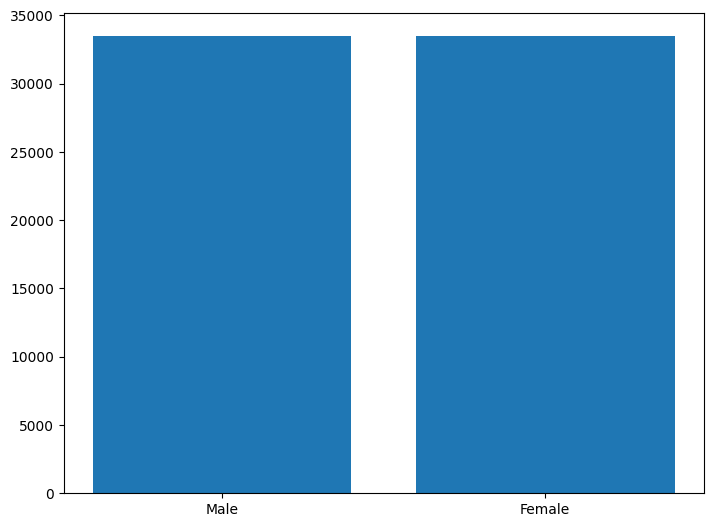

In [87]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
gender=["Male","Female"]
values=[33469,33469]
ax.bar(gender,values)
plt.show()

In [88]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(vector_length=128):
    if not os.path.isdir("results"):
        os.mkdir("results")
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    df = pd.read_csv("balanced-all.csv")
    n_samples = len(df)
    n_male_samples = len(df[df['gender'] == 'male'])
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    X = np.zeros((n_samples, vector_length))
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [89]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [90]:
X, y = load_data()
data = split_data(X, y, test_size=0.1, valid_size=0.1)

In [91]:
data["y_train"][0:5]

array([[1.],
       [1.],
       [1.],
       [0.],
       [0.]])

In [92]:
Y_train_2=data["y_train"][:]
Y_test_2=data["y_test"][:]

In [93]:
Y_train_2[0][0:5]

array([1.])

In [94]:
Y_train_2[1][0:5]

array([1.])

In [95]:
def create_model(vector_length=128):
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    model.summary()
    return model

In [96]:
model = create_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 128)              

In [97]:
tensorboard = TensorBoard(log_dir="logs")
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)
batch_size = 64
epochs = 100
history=model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]), callbacks=[tensorboard, early_stopping])

Epoch 1/100
848/848 [==============================] - 9s 8ms/step - loss: 0.5586 - accuracy: 0.7668 - val_loss: 0.3845 - val_accuracy: 0.8470
Epoch 2/100
848/848 [==============================] - 6s 8ms/step - loss: 0.4154 - accuracy: 0.8345 - val_loss: 0.3398 - val_accuracy: 0.8656
Epoch 3/100
848/848 [==============================] - 7s 8ms/step - loss: 0.3854 - accuracy: 0.8508 - val_loss: 0.3244 - val_accuracy: 0.8714
Epoch 4/100
848/848 [==============================] - 7s 8ms/step - loss: 0.3609 - accuracy: 0.8598 - val_loss: 0.3011 - val_accuracy: 0.8782
Epoch 5/100
848/848 [==============================] - 6s 8ms/step - loss: 0.3460 - accuracy: 0.8666 - val_loss: 0.2863 - val_accuracy: 0.8910
Epoch 6/100
848/848 [==============================] - 6s 8ms/step - loss: 0.3423 - accuracy: 0.8686 - val_loss: 0.2917 - val_accuracy: 0.8860
Epoch 7/100
848/848 [==============================] - 6s 8ms/step - loss: 0.3281 - accuracy: 0.8748 - val_loss: 0.2810 - val_accuracy: 0.8878

In [98]:
model.save("results/model.h5")

In [99]:
model.evaluate(data["X_test"],Y_test_2)

210/210 [==============================] - 1s 4ms/step - loss: 0.2284 - accuracy: 0.9181


[0.2283858209848404, 0.9181356430053711]

In [100]:
pred=model.predict(data["X_test"])

210/210 [==============================] - 1s 3ms/step


In [101]:
pred[1]

array([0.9578192], dtype=float32)

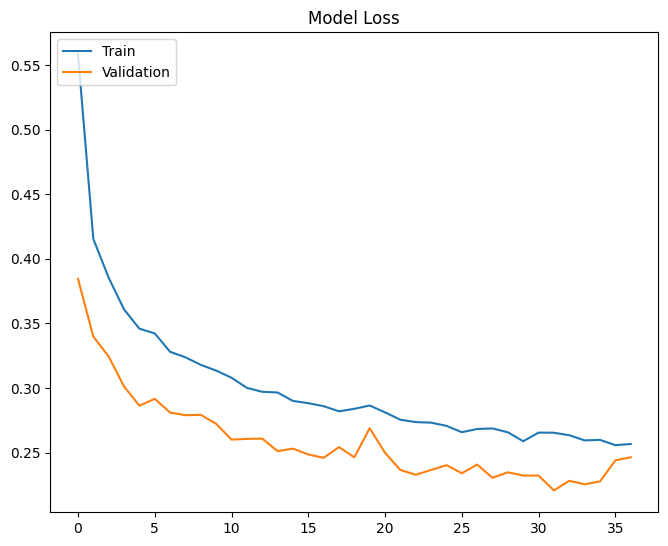

In [102]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel=('Epoch')
plt.ylabel=('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

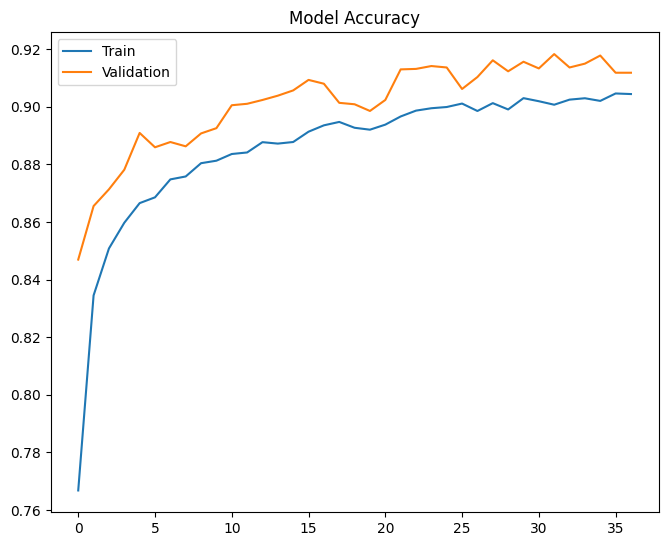

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel=("Epoch")
plt.ylabel=('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

In [104]:
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 6694 samples...
Loss: 0.2284
Accuracy: 91.81%
